In [7]:
import numpy as np
%pylab
%matplotlib inline


import skimage.io as sk
from Functions import image_processing as ip
from Functions import region_merging as rm
from Functions import seeded_region_growing as srg
from Functions import seed_detection as sd


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [8]:
def find_neigboring_regions(reg):
    """

    :param reg:
    :return:
    """
    max_region = max(reg.flatten())
    inter_region_neighbors = np.zeros((int(max_region), int(max_region)))
    for region_number in range(1, int(max_region)+1):
        neighboring_regions = find_neighbors_one_region(reg, region_number)
        inter_region_neighbors[int(region_number)-1, neighboring_regions - 1] = 1
    inter_region_neighbors = np.triu(inter_region_neighbors)  # upper triangle
    return inter_region_neighbors


def find_neighbors_one_region(reg, region_number):
    """

    :param reg:
    :param region_number:
    :return:
    """
    neighboring_regions = np.zeros((reg.shape[0] + 2, reg.shape[1] + 2))
    reg = ip.add_border(reg)
    reg = reg.astype(int)
    pos_pixel_region = np.where(reg == region_number)

    neighboring_regions[pos_pixel_region[0], pos_pixel_region[1] - 1] = reg[
        pos_pixel_region[0], pos_pixel_region[1] - 1]
    neighboring_regions[pos_pixel_region[0], pos_pixel_region[1] + 1] = reg[
        pos_pixel_region[0], pos_pixel_region[1] + 1]
    neighboring_regions[pos_pixel_region[0] - 1, pos_pixel_region[1]] = reg[
        pos_pixel_region[0] - 1, pos_pixel_region[1]]
    neighboring_regions[pos_pixel_region[0] + 1, pos_pixel_region[1]] = reg[
        pos_pixel_region[0] + 1, pos_pixel_region[1]]

    neighboring_regions[pos_pixel_region[0], pos_pixel_region[1]] = 0
    neighboring_regions_unique = np.unique(neighboring_regions.flatten())
    pos_zero = np.where(neighboring_regions_unique == 0)
    neighboring_regions_unique = np.delete(neighboring_regions_unique, pos_zero[0])
    #neighboring_regions_unique = neighboring_regions_unique.tolist()
    neighboring_regions_unique = neighboring_regions_unique.astype(int)
    return neighboring_regions_unique


def region_distance(img, reg):
    """
    calculates distance between all regions
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :return: 2d array with distances between all regions, only in upper pyramid
    (region numbers are row and col number)
    inter_region_distances is upper triangle matrix with mean intensity distances between regions (2d array)
    mean values of all regions (list of floats)
    """

    max_region = int(max(reg.flatten()))
    max_intensity = np.amax(img)
    inter_region_distances = np.ones((int(max_region), int(max_region)))
    means = srg.mean_region(img, reg)
    inter_region_neighbors = find_neigboring_regions(reg)

    for row_number in range(0, int(max_region)):
        neighboring_regions = np.where(inter_region_neighbors[row_number, :] == 1)[0]
        for col_number in neighboring_regions:
            inter_region_distances[row_number][col_number] = distance_between_regions(row_number, col_number,
                                                                                      max_intensity, means)
    return inter_region_distances, means, inter_region_neighbors


def distance_between_regions(region1, region2, max_intensity, means):
    distance = abs(means[region1] - means[region2]) / max_intensity
    return distance


def one_merged_region_mean(img, reg, region_number):
    """
    calculates the mean of changed region
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :param region_number: number of the changed region (int)
    :return: mean value of changed position (float)
    """
    pos_new_reg = np.where(reg == region_number)
    single_mean = np.mean(img[pos_new_reg[0], pos_new_reg[1]])
    return single_mean


def region_distance_new(img, reg, pos_min_dist, means, inter_region_distances, inter_region_neighbors):
    """
    updates array of distances of mean intensity values between all changed regions
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :param pos_min_dist: region number of changed regions (tuple(x,y), pos_min_dist[0] is resulting region number,
                         pos_min_dist[1] is region_number to be removed)
    :param means: mean values of all regions (list of floats)
    :param inter_region_distances: distances between mean intensity values of regions (2d array)
    :param inter_region_neighbors:
    :return: inter_region_distances: updated distances between mean intensity values of regions
    """

    region_count = inter_region_distances.shape[0]
    maximal_intensity = np.amax(img)
    changed_region1 = int(pos_min_dist[0])  # Regions Nummer 1 die übernommen wird
    changed_region2 = int(pos_min_dist[1])
    means = update_mean_values(means, changed_region1, changed_region2, img, reg)
    inter_region_distances = update_distances(changed_region1, changed_region2, inter_region_distances, region_count,
                                              means, maximal_intensity, inter_region_neighbors)
    return inter_region_distances


def update_distances(changed_region1, changed_region2, inter_region_distances, region_count, means, maximal_intensity,
                     inter_region_neighbors):
    """
    updates distance values of changed regions, value 500 for removed regions
    :param changed_region1: resulting region number for merged region
    :param changed_region2: region number which is going to be removed
    :param inter_region_distances: distances between mean intensity values of regions (2d array)
    :param region_count: amount of different regions at beginning of merging process (int)
    :param means: mean intensity values of regions (list)
    :param maximal_intensity: maximal intensity value of image
    :param inter_region_neighbors:
    :return: updated inter_region distances (2d array)
    """
    neighboring_regions = np.where(inter_region_neighbors[changed_region1, :] != 0)[0]
    for col_number in neighboring_regions:
        if col_number > changed_region1:
            inter_region_distances[changed_region1][col_number] = distance_between_regions(changed_region1, col_number,
                                                                                           maximal_intensity, means)
    for row_number in neighboring_regions:
        if row_number < changed_region1:
            inter_region_distances[row_number][changed_region1] = distance_between_regions(changed_region1, row_number,
                                                                                           maximal_intensity, means)
    inter_region_distances[changed_region2][0:region_count] = 500
    inter_region_distances[0:region_count][changed_region2] = 500
    return inter_region_distances


def update_neighboring_regions(inter_region_neighbors, changed_region1, changed_region2):
    inter_region_neighbors[changed_region1, :] = inter_region_neighbors[changed_region1, :] + inter_region_neighbors[
                                                                                              changed_region2, :]
    return inter_region_neighbors


def update_mean_values(means, changed_region1, changed_region2, img, reg):
    """
    updates mean value for merged regions in list of mean values, value 500 for unused means
    :param means: mean intensity values of regions (list of ints)
    :param changed_region1: region number for merged region (int)
    :param changed_region2: region number to be removed (int)
    :param img: intensity values (2d array)
    :param reg: region numbers (2d array)
    :return:
    """
    means[changed_region2] = 500
    means[changed_region1] = one_merged_region_mean(img, reg, changed_region1 + 1)
    return means


def position_of_minimal_distance(dis, min_distance):
    minimal_distances = np.where(dis == min_distance)
    pos_min_dist = list(zip(minimal_distances[0], minimal_distances[1]))[0]
    pos_min_dist = (int(pos_min_dist[0]), int(pos_min_dist[1]))
    return pos_min_dist


def updates_region_numbers(inter_region_distances, reg, min_distance):
    """
    changes region number to region number of merged region
    :param inter_region_distances: distances between mean intensity values of regions (2d array)
    :param reg: region numbers (2d array)
    :param min_distance: minimal distance of mean intensity values between to regions

    :return: reg: updated region numbers (2d array)1
    :return: pos_min_dist: position of minimal distance in inter_region_distances array (tuple(x,y))
    """
    pos_min_dist = position_of_minimal_distance(inter_region_distances, min_distance)

    pixel_to_change = np.where(reg == pos_min_dist[
        1] + 1)  # column in inter_region_distances is region to be changed(column number bigger than row number)
    pixel_to_change_rows = pixel_to_change[0]
    pixel_to_change_cols = pixel_to_change[1]
    reg[pixel_to_change_rows, pixel_to_change_cols] = pos_min_dist[0] + 1
    return reg, pos_min_dist


def distance_merging_while(reg, threshold, img):
    """
    region merging algorithm by similarity of mean intensity values of regions
    :param reg: region numbers (2d array)
    :param threshold: distance intensity value below which regions are merged (float between 0 and 1)
    :param img: intensity value (2d array)
    :return: merged regions by intensity similarity (2d array)
    """

    result_region_distance = region_distance(img, reg)
    inter_region_distances = result_region_distance[0]
    means = result_region_distance[1]
    inter_region_neighbors = result_region_distance[2]

    min_distance = np.nanmin(inter_region_distances)
    while minimal_distance_is_similar(threshold, min_distance):
        updated_regions = updates_region_numbers(inter_region_distances, reg, min_distance)
        reg = updated_regions[0]
        pos_min_dist = updated_regions[1]

        inter_region_neighbors = update_neighboring_regions(inter_region_neighbors, pos_min_dist[0], pos_min_dist[1])
        inter_region_distances = region_distance_new(img, reg, pos_min_dist, means, inter_region_distances,
                                                     inter_region_neighbors)
        min_distance = np.nanmin(inter_region_distances)
    return reg


def minimal_distance_is_similar(threshold, min_distance):
    if min_distance < threshold:
        return True
    return False



C:\Users\marie\anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
C:\Users\marie\Documents\Studium\Semester4\Bioinfo\Projekt\Functions\seed_detection.py:51: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list
C:\Users\marie\Documents\Studium\Semester4\Bioinfo\Projekt\Functions\seed_detection.py:51: RuntimeWarning: invalid value encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list
C:\Users\marie\Documents\Studium\Semester4\Bioinfo\Projekt\Functions\seed_detection.py:51: RuntimeWarning: divide by zero encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / img[p])  # adds relative euclidean distance to list


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


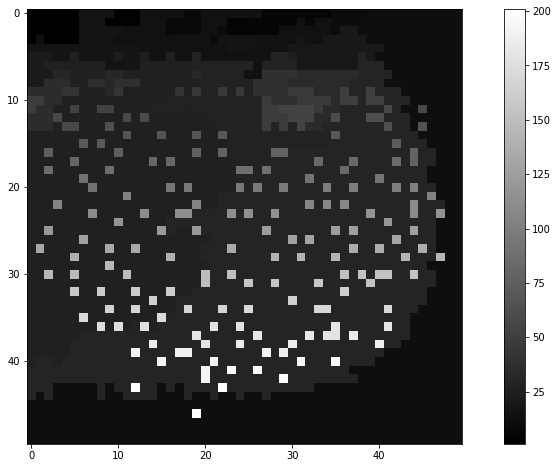

In [9]:
image_intensity = sk.imread("../Data/N2DH-GOWT1/img/t01.tif")  # load image
image_intensity = image_intensity[300:350, 450:500]
image_r = sd.seeds(image_intensity, 0.1, 1)
image_r = sd.seed_merging(image_r)
image_r = srg.region_growing(image_intensity, image_r)
ip.show_image(image_r,15,8)


In [10]:
image_r_copy = image_r.copy()
image_r_copy = distance_merging_while(image_r_copy,0.05,image_intensity)
ip.show_image(image_r_copy,15,8)
#tets

TypeError: mean_region() takes 1 positional argument but 2 were given